In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import shuffle
import shap

In [3]:
# Changes the font parameters for the charts
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [4]:
params = {}

In [5]:
## Change to the 'Datasets directory'
initial_dir = os.getcwd()
data_folder = os.path.join(os.getcwd(), 'Datasets')
data_path = os.path.join(data_folder, "data")

In [232]:
target = 'deaths'
drop_cols = ['dateRep', 'cases', 'deaths18']

In [233]:
## Import the train and test dataframes. Drop the 'dateRep' column as it is not need for the prediciton.
train_X = pd.read_csv(os.path.join(data_path, "train", 'train_x.csv'), index_col=0).drop(columns=['dateRep', 'flag']).sample(frac=1, random_state=1)
train_y = pd.read_csv(os.path.join(data_path, "train", 'train_y.csv'), index_col=0).drop(columns=drop_cols).sample(frac=1, random_state=1)
## '.sample' randomises the dataframe as the validation test below will take the bottom 20% of the data
## 'frac=1' means it will use all the data and 'random_state=1' keeps the resample consistent between df's
test_x = pd.read_csv(os.path.join(data_path, "test", 'test_x.csv'), index_col=0).drop(columns=['dateRep', 'flag']).sample(frac=1, random_state=1)
test_y = pd.read_csv(os.path.join(data_path, "test", 'test_y.csv'), index_col=0).drop(columns=drop_cols).sample(frac=1, random_state=1)

In [234]:
train_y.head()

,deaths
2803,54
568,0
485,0
1365,843
2300,54


In [235]:
## Initialise Scalars so that data is normalised to 1.
sc_x = StandardScaler()
sc_y = StandardScaler()
## Normalise the data using the scalar.
X_train = sc_x.fit_transform(train_X)
X_test = sc_x.transform(test_x)

y_train = sc_y.fit_transform(train_y)
y_test = sc_y.transform(test_y)

In [236]:
## Calculate the number of input 'test' columns.
input_neuron = len(test_x.columns)
input_neuron

10

In [237]:
## Setup the model for training.
classifier = Sequential()
classifier.add(Dense(output_dim = 250, init = 'uniform', activation = 'relu', input_dim = input_neuron))
classifier.add(Dense(output_dim = 150, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 75, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 30, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'linear'))

classifier.compile(optimizer = 'Nadam', loss = 'mean_squared_error', metrics = ["mae"])
history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 1000, validation_split= 0.2)

Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=10, units=250, kernel_initializer="uniform")`
Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=150, kernel_initializer="uniform")`
Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=75, kernel_initializer="uniform")`
Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=30, kernel_initializer="uniform")`
Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1, kernel_initializer="uniform")`


Train on 159 samples, validate on 40 samples
Epoch 1/1000
159/159 [==============================] - 1s 6ms/step - loss: 0.9179 - mae: 0.6963 - val_loss: 0.4567 - val_mae: 0.4740
Epoch 2/1000
159/159 [==============================] - 0s 372us/step - loss: 0.3763 - mae: 0.3957 - val_loss: 0.5633 - val_mae: 0.4613
Epoch 3/1000
159/159 [==============================] - 0s 333us/step - loss: 0.2798 - mae: 0.3087 - val_loss: 0.2677 - val_mae: 0.3600
Epoch 4/1000
159/159 [==============================] - 0s 328us/step - loss: 0.2211 - mae: 0.2642 - val_loss: 0.0673 - val_mae: 0.1566
Epoch 5/1000
159/159 [==============================] - 0s 332us/step - loss: 0.1835 - mae: 0.2377 - val_loss: 0.0687 - val_mae: 0.1591
Epoch 6/1000
159/159 [==============================] - 0s 332us/step - loss: 0.1928 - mae: 0.2408 - val_loss: 0.1199 - val_mae: 0.1957
Epoch 7/1000
159/159 [==============================] - 0s 325us/step - loss: 0.2131 - mae: 0.2588 - val_loss: 0.0687 - val_mae: 0.1810
Epoch

In [238]:
model_path = os.path.join(data_folder, "model")
# Check if the relevant folders exist and create them if not
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
# Export the model for future use to that you don't need to spend time training the model again
pickle.dump(classifier, open(os.path.join(model_path, "ReinNN_UK.pkl"), "wb"))

In [239]:
"""model_path = os.path.join(data_folder, "model")
# Import the exported model in future runs using the greyed out line below (remove the hastag)
model = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))"""

'model_path = os.path.join(data_folder, "model")\n# Import the exported model in future runs using the greyed out line below (remove the hastag)\nmodel = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))'

In [240]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(classifier, X_train)
shap_values = explainer.shap_values(X_train)

In [241]:
names= train_X.columns.to_list()
#names = 

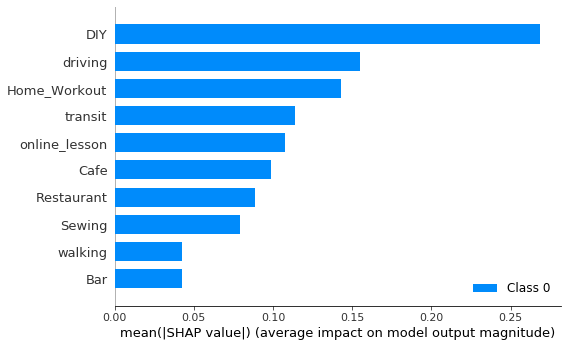

In [242]:
shap.summary_plot(shap_values, X_train, names, plot_type="bar", show=False)
#plt.savefig('SHAP_Feature_Score_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

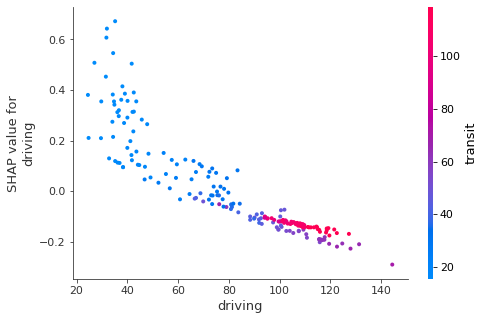

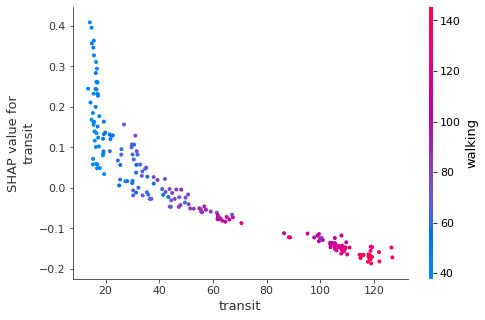

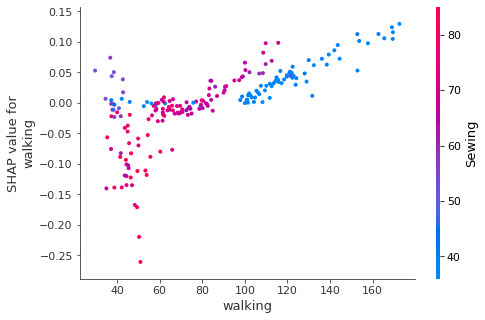

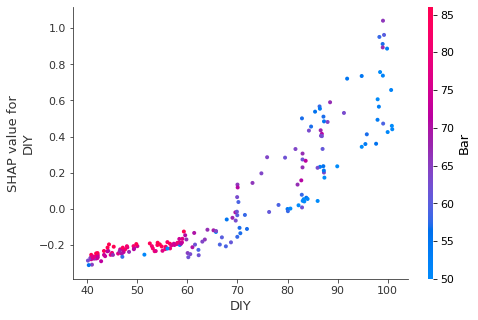

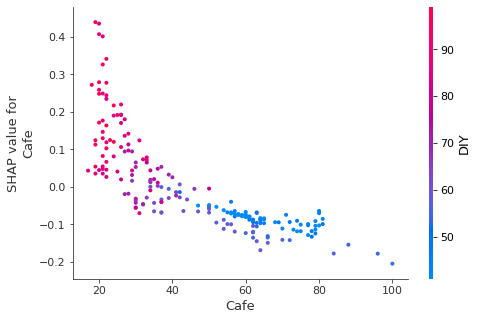

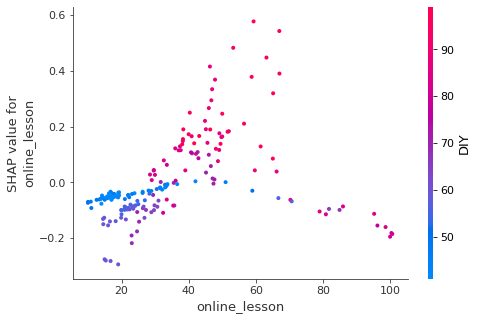

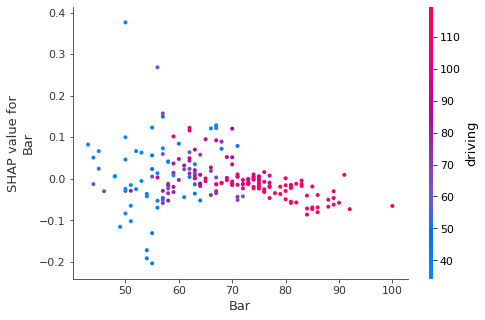

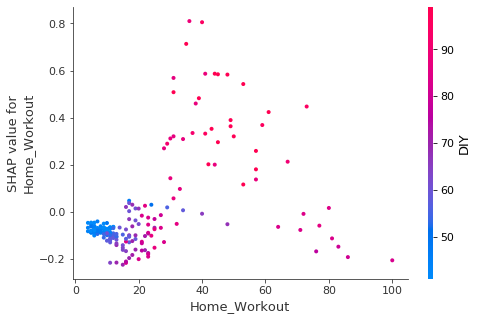

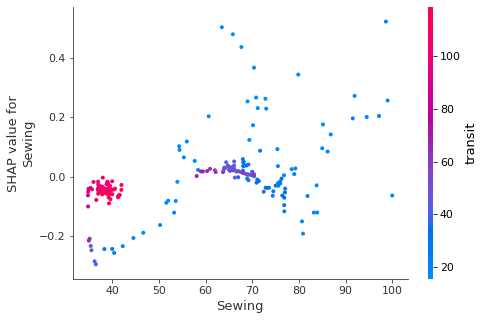

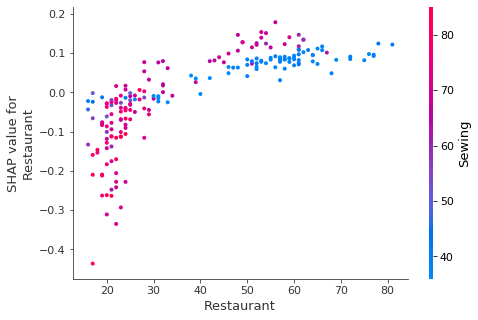

In [243]:
for i in names:
    # SHAP asigned value for an input parameter vs its value. Coloured by a random input feature
    shap.dependence_plot(i, shap_values[0], train_X)

In [244]:
shap.force_plot(explainer.expected_value, shap_values[0], train_X)

In [245]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_x.iloc[0,:], link="logit")

In [246]:
# Calculate the predicted deaths according to the neural net model
test_x["deaths_pred"] = sc_y.inverse_transform(classifier.predict(X_test))
# Calculate the predicted deaths according to the neural net model
#train_X["deaths_pred"] = sc_y.inverse_transform(classifier.predict(X_train))
#df1 = pd.concat([test_x, train_X], axis=1)
df= train_X.merge(train_y,left_index=True, right_index=True)
# We merge the test dataframes together
df1 = test_x.merge(test_y, left_index=True, right_index=True)
# We append the test data to the train data
df = df.append(df1)

In [247]:
## Calculate the mean absolute error and R2 scores for the predicted vs real data.
print(f"DL MAE score: {np.round(mean_absolute_error(df1[target], df1.deaths_pred))}")
print(f"DL R2 score: {np.round(r2_score(df1[target], df1.deaths_pred), 4)}")

DL MAE score: 13.0
DL R2 score: -4.6798


In [255]:
# Again read in the 'covid19_df' as df_global
df_global = pd.read_csv(os.path.join(data_folder, "Data_Export", "covid19_df.csv"), index_col=0)
df_global['dateRep'] = pd.to_datetime(df_global['dateRep'])
# Merge in the 'deaths_pred' prediction column to compare to the real data
df_global = df_global.merge(df["deaths_pred"], left_index=True, right_index=True, how='left')

In [256]:
#df_global['deaths_pred'] = df_global.groupby('countriesAndTerritories')['deaths_pred'].shift(periods=18)

In [257]:
# Compute the prediction error
df_global['deaths_pred_error'] = df_global['deaths'] - df_global['deaths_pred']
# Compute the cumulative error for each country individually
df_global['cumulative_error'] = df_global.groupby('countriesAndTerritories')['deaths_pred_error'].cumsum()

In [258]:
# Recreate the 'top_count' list to create the graphs below
top_count = list(df_global.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20].keys())

In [259]:
df_global.loc[df_global['countriesAndTerritories']=='United_Kingdom'].tail()

,dateRep,cases,deaths,countriesAndTerritories,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,Cum_Cases,Cum_Deaths,flag,...,Cafe,online_lesson,Bar,Home_Workout,Sewing,Restaurant,deaths18,deaths_pred,deaths_pred_error,cumulative_error
3456,2020-08-15,1440,11,United_Kingdom,66647112.0,Europe,19.784803,316367,41358,165.0,...,85.0,21.368743,92.0,6.0,55.678503,76.0,13.0,11.772799,-0.772799,-40.896685
3462,2020-08-16,1077,3,United_Kingdom,66647112.0,Europe,20.243938,317444,41361,166.0,...,93.0,24.000000,87.0,7.0,56.000000,79.0,13.0,7.568179,-4.568179,-45.464864
3480,2020-08-17,1040,5,United_Kingdom,66647112.0,Europe,20.689569,318484,41366,167.0,...,84.0,24.000000,87.0,7.0,56.000000,94.0,13.0,33.025166,-28.025166,-73.490030
3500,2020-08-18,713,3,United_Kingdom,66647112.0,Europe,20.366974,319197,41369,168.0,...,86.0,24.000000,89.0,10.0,56.000000,100.0,13.0,23.456516,-20.456516,-93.946546
3511,2020-08-19,1089,12,United_Kingdom,66647112.0,Europe,20.995658,320286,41381,169.0,...,86.0,24.000000,89.0,10.0,56.000000,100.0,13.0,21.890553,-9.890553,-103.837098


In [ ]:
    # Visualising the features.
    fig, ax1 = plt.subplots()
    j = 'Bar'
    country = m
    target = 'deaths'
    ax2 = ax1.twinx()
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Google Search Requests', c='darkviolet', linewidth=2)
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][target], label=country + ' Daily ' + target.capitalize(), c='mediumblue', linewidth=2)
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country]['deaths18'], label=country + ' Daily ' + target.capitalize()+' - 18 days', c='crimson', linewidth=2)

    plt.title(target.capitalize() + ' vs Google Search Requests')
    plt.grid()
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.set_size_inches(18.5, 10.5)

    ax1.set_xlabel('Days Since 100th Case')
    ax1.set_ylabel(j.capitalize() + ' Google Search Requests')
    ax2.set_ylabel('Number of Daily ' + target.capitalize())
    #plt.savefig(i + 'Feature.jpeg', dpi=600)"""

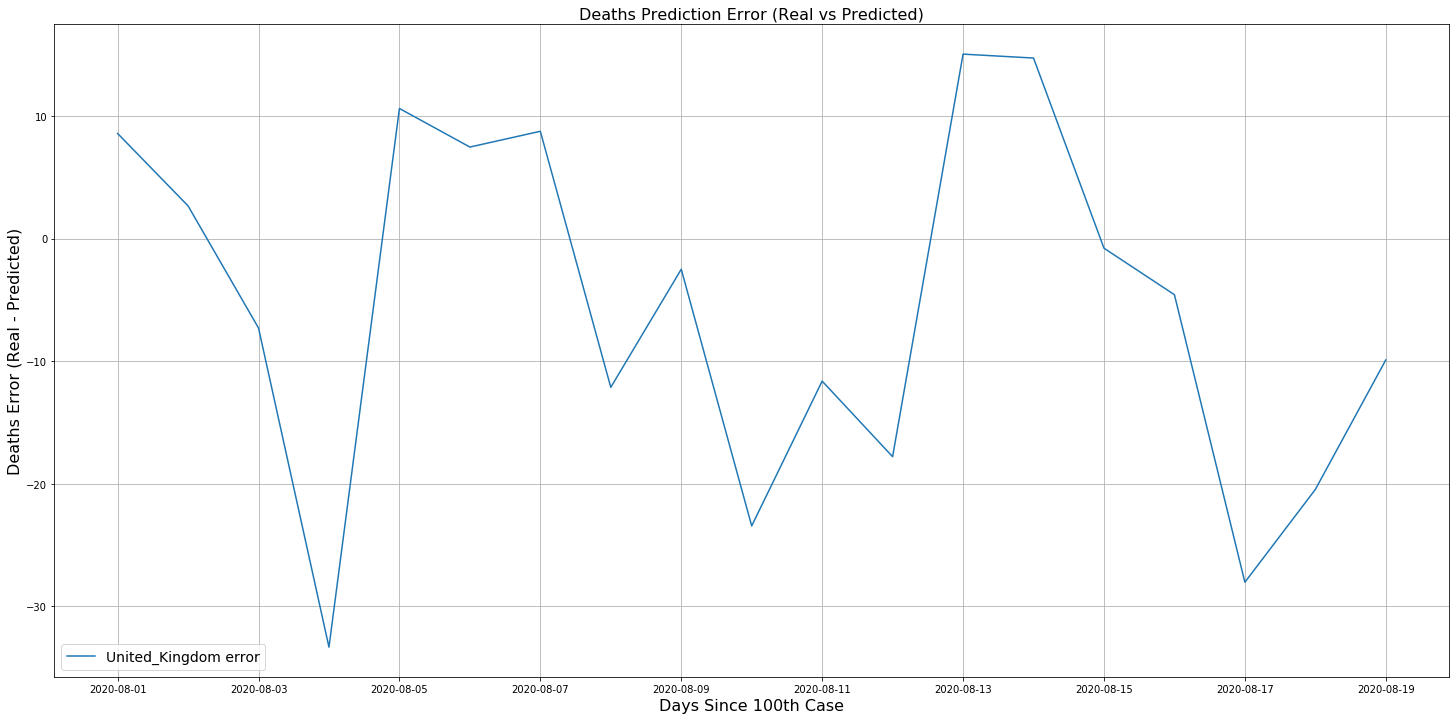

In [260]:
# Visualising the Linear Regression results
country = 'United_Kingdom'
plt.figure(figsize=(25, 12))
plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
         df_global[df_global["countriesAndTerritories"] == country]['deaths_pred_error'], label=f"{country} error")
plt.title('Deaths Prediction Error (Real vs Predicted)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Deaths Error (Real - Predicted)')
plt.grid()
plt.legend(ncol=2, loc=3)

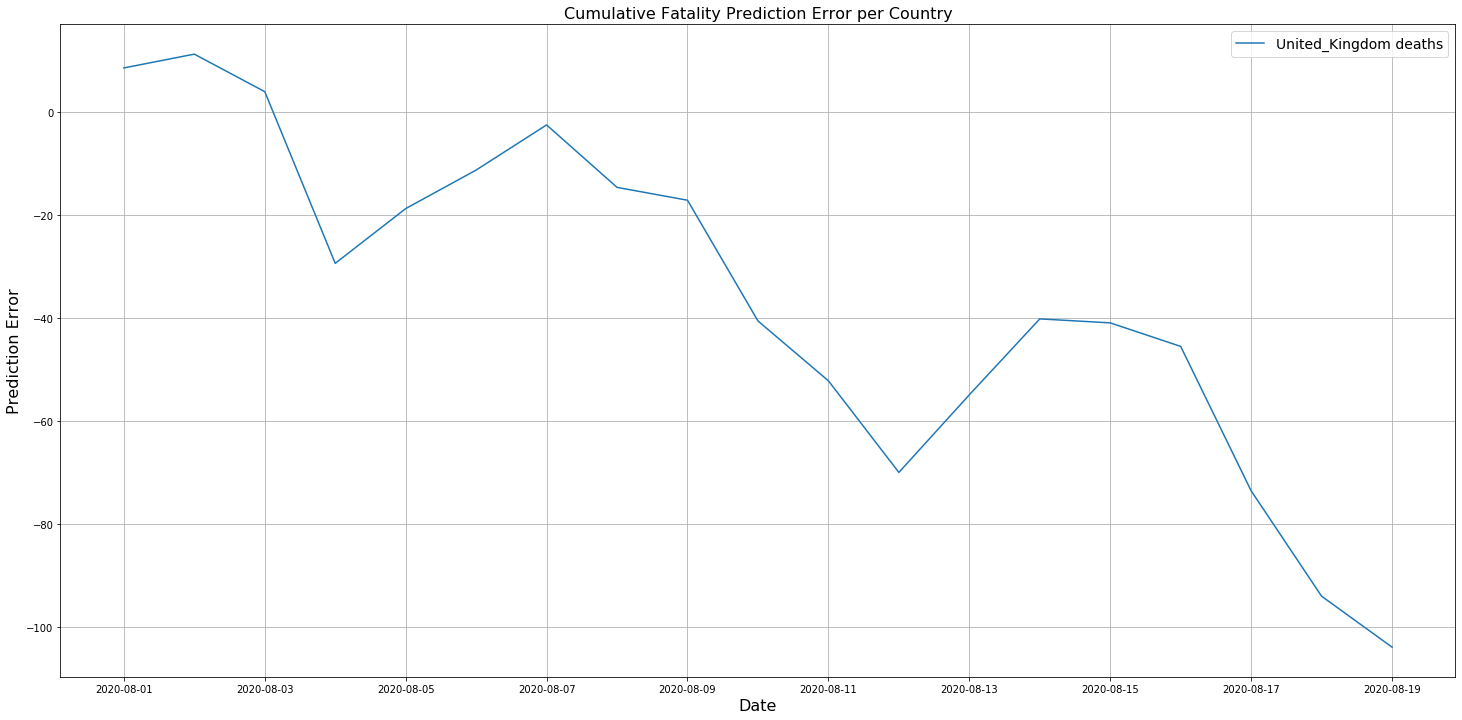

In [261]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
country = 'United_Kingdom'
plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
         df_global[df_global["countriesAndTerritories"] == country]['cumulative_error'], label=f"{country} deaths")
plt.title('Cumulative Fatality Prediction Error per Country')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid()
plt.legend(ncol=2)
#plt.savefig('cumulative_error_20_nn_countries_dpi300.jpeg', dpi=300)

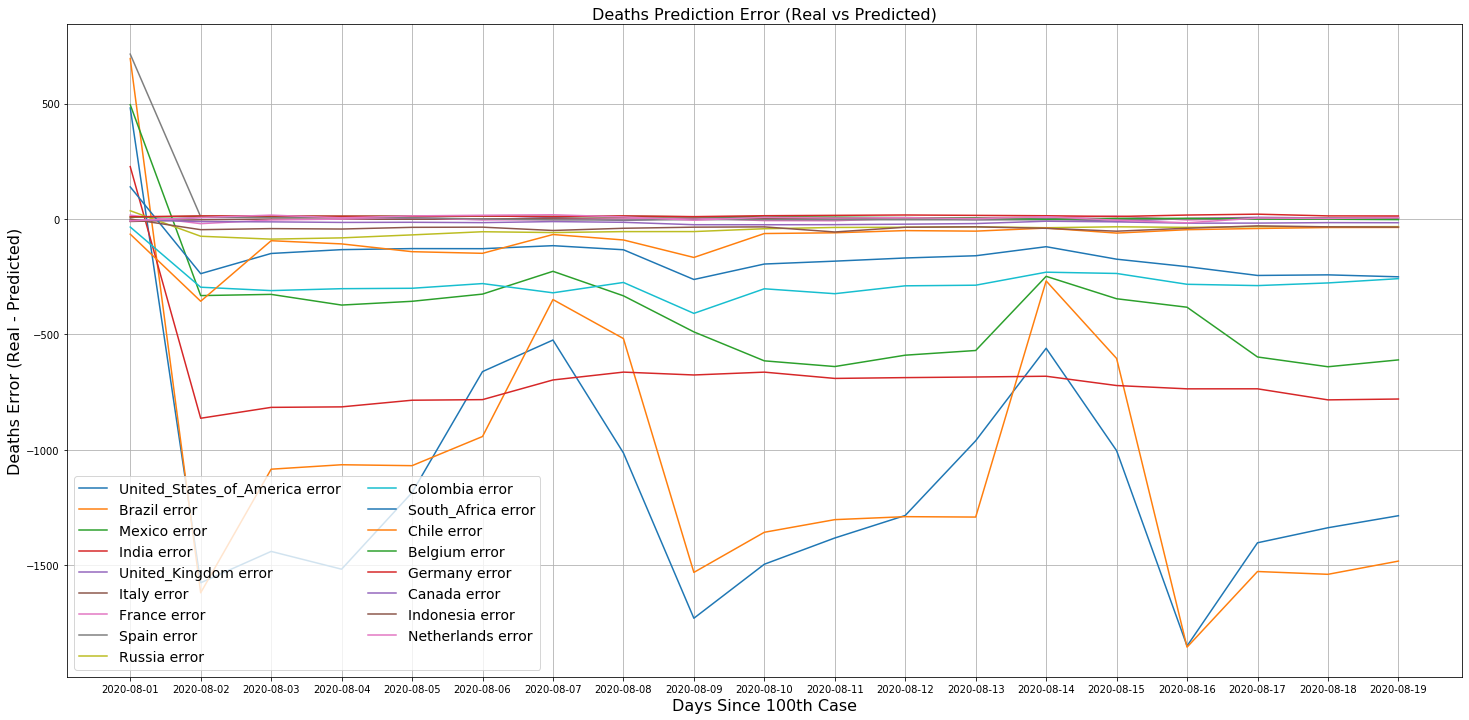

In [33]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['deaths_pred_error'], label=f"{country} error")
plt.title('Deaths Prediction Error (Real vs Predicted)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Deaths Error (Real - Predicted)')
plt.grid()
plt.legend(ncol=2, loc=3)

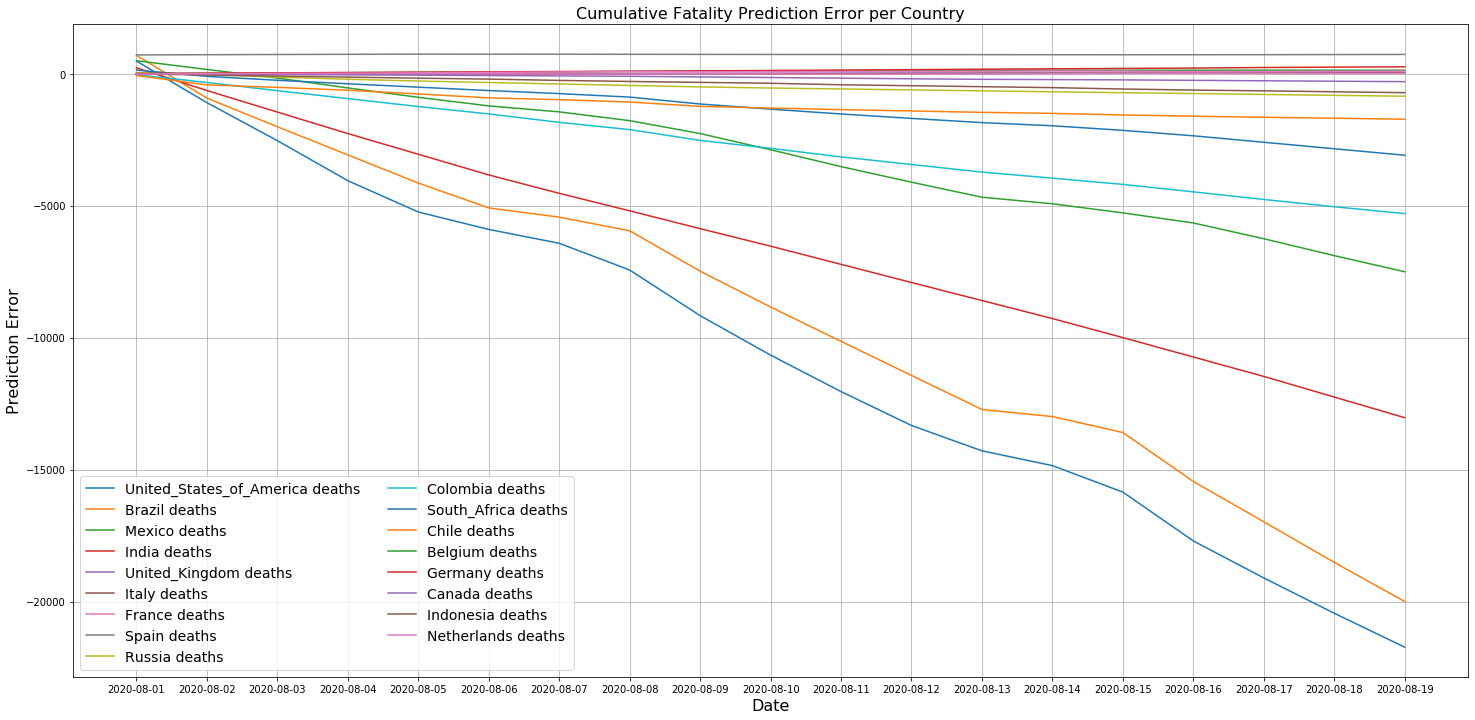

In [34]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['cumulative_error'], label=f"{country} deaths")
plt.title('Cumulative Fatality Prediction Error per Country')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid()
plt.legend(ncol=2)
#plt.savefig('cumulative_error_20_nn_countries_dpi300.jpeg', dpi=300)

In [19]:
## Check for the directory and output the df_global dataframe.
if os.path.exists(os.path.join(data_folder, "model_predictions")) is False:
    os.mkdir(os.path.join(data_folder, "model_predictions"))
df_global.to_csv(os.path.join(data_folder, "model_predictions", "Rein_nn_predictions.csv"))

In [20]:
#plt.style.use("ggplot")

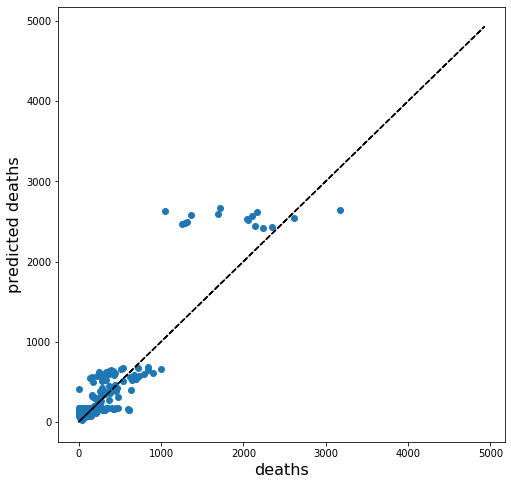

In [21]:
## Plot deaths vs predicted.
plt.figure(figsize=(8, 8))
plt.scatter(df.deaths, df.deaths_pred)
plt.plot(df.deaths, df.deaths, color="black", linestyle="--")
plt.xlabel("deaths")
plt.ylabel("predicted deaths")
plt.show()